In [34]:
%cd python

[WinError 2] The system cannot find the file specified: 'python'
C:\Users\kisha\Documents\LRP_Demo\python


# Notebook to play around the different threshold, digits and methods

In [35]:
import matplotlib.pyplot as plt
import time
import numpy
import numpy as np
import importlib.util as imp
if imp.find_spec("cupy"): #use cupy for GPU support if available
    import cupy
    import cupy as np
na = np.newaxis

import model_io
import data_io
import render
# import cv2

In [36]:
#load a neural network, as well as the MNIST test data and some labels
nn = model_io.read('../mnist_mlp-full.txt') # 99.16% prediction accuracy
nn.drop_softmax_output_layer() #drop softnax output layer for analyses

loading plain text model from ../mnist_mlp-full.txt
removing softmax output mapping


In [37]:
nn_target = model_io.read('../mnist_to_letter.txt') # 99.16% prediction accuracy
nn_target.drop_softmax_output_layer() #drop softnax output layer for analyses

loading plain text model from ../mnist_to_letter.txt
removing softmax output mapping


In [50]:
X = data_io.read('../data/EMNIST/Emnist_test_images.npy')
Y = data_io.read('../data/EMNIST/Emnist_test_labels.npy')

loading np-formatted data from ../data/EMNIST/Emnist_test_images.npy
loading np-formatted data from ../data/EMNIST/Emnist_test_labels.npy


In [51]:
# transfer pixel values from [0 255] to [-1 1] to satisfy the expected input / training paradigm of the model
X =  X / 127.5 - 1

In [52]:
# transform numeric class labels to vector indicator for uniformity. assume presence of all classes within the label set
I = Y.astype(int) - 1
Y = np.zeros([X.shape[0],np.unique(Y).size])
Y[np.arange(Y.shape[0]),I] = 1

In [53]:
acc = np.mean(np.argmax(nn_target.forward(X), axis=1) == np.argmax(Y, axis=1))
if not np == numpy: # np=cupy
    acc = np.asnumpy(acc)
print('Target model test accuracy is: {:0.4f}'.format(acc))

Target model test accuracy is: 0.8539


In [54]:
#permute data order for demonstration. or not. your choice.
I = np.arange(X.shape[0])
#I = np.random.permutation(I)

In [69]:
#Select a Digit between 5-9
clas = 10
for i in I:
  if np.argmax(Y[i])+5 == clas:
    break


In [70]:
#Find Relevance using Base network

x = X[na,i,:]

#forward pass and prediction
ypred = nn.forward(x)
print('True label:     ', np.argmax(Y[i])+5)
print('Predicted label:', np.argmax(ypred),'\n')
print('Prediction Score 0-4', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

R_base = []
#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
lrp_type = ["simple", "alphabeta", "epsilon", "ww"]
lrp_t = [1, 3, 0.01, 1]
for k in range(len(lrp_type)):
    R_base.append(nn.lrp(Rinit, lrp_type[k], lrp_t[k]))
    
    


#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)
    for k in range(len(lrp_type)):
        R_base[k] = np.asnumpy(R_base[k])

# print(len(R[0]))
#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_base = []
for k in range(len(lrp_type)):
    hm_base.append(render.hm_to_rgb(R_base[k], X = x, scaling = 3, sigma = 2))
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# # display the image as written to file
# plt.imshow(hm_base, interpolation = 'none')
# plt.axis('off')
# plt.show()

True label:      10
Predicted label: 7 

Prediction Score 0-4 [[-0.55949041 -3.71026634 -0.44256789  1.24442351 -4.45011016 -0.56526612
  -9.91935329 13.87313521 -7.43423224 10.84246508]]


In [71]:
#Find Relevance using Target network

x = X[na,i,:]

#forward pass and prediction
ypred = nn_target.forward(x)
print('True label:     ', np.argmax(Y[i])+5)
print('Predicted label:', np.argmax(ypred)+5,'\n')
print('Prediction Score 5-9', ypred)

#prepare initial relevance to reflect the model's dominant prediction (ie depopulate non-dominant output neurons)
mask = np.zeros_like(ypred)
mask[:,np.argmax(ypred)] = 1
Rinit = ypred*mask

#compute first layer relevance according to prediction
#R = nn.lrp(Rinit)                   #as Eq(56) from DOI: 10.1371/journal.pone.0130140
# R_target_0 = nn_target.lrp(Rinit,'simple', 3, reset=0)    #as Eq(58) from DOI: 10.1371/journal.pone.0130140
#R = nn.lrp(Rinit,'alphabeta',2)    #as Eq(60) from DOI: 10.1371/journal.pone.0130140
# print(R_target)
# print(max(R_target[0]), min(R_target[0]))
reset_values = [0, 1, 2, 3]
R_target = {"simple":[], "alphabeta":[], "epsilon":[], "ww":[], "flat":[]}
for k in range(len(lrp_type)):
    for j in range(len(reset_values)):
        if lrp_type[k] == "alphabeta":
            epsilon = 3
        elif lrp_type[k] == "epsilon":
            epsilon = 0.01
        else:
            epsilon = 2
        R_target[lrp_type[k]].append(nn_target.lrp(Rinit, lrp_type[k], epsilon, reset_values[j], t_A=10, t_R=10))
        
        

#R = nn.lrp(ypred*Y[na,i]) #compute first layer relevance according to the true class label
'''
yselect = 3
yselect = (np.arange(Y.shape[1])[na,:] == yselect)*1.
R = nn.lrp(ypred*yselect) #compute first layer relvance for an arbitrarily selected class
'''

#undo input normalization for digit drawing. get it back to range [0,1] per pixel
x = (x+1.)/2.

if not np == numpy: # np=cupy
    x = np.asnumpy(x)

#render input and heatmap as rgb images
digit = render.digit_to_rgb(x, scaling = 3)
hm_target = {"simple":[], "alphabeta":[], "epsilon":[], "ww":[], "flat":[]}
for k in range(len(lrp_type)):
    for j in range(len(reset_values)):
        hm_target[lrp_type[k]].append(render.hm_to_rgb(R_target[lrp_type[k]][j], X = x, scaling = 3, sigma = 2))
        
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# #display the image as written to file
# plt.imshow(hm_target, interpolation = 'none')
# plt.axis('off')
# plt.show()

True label:      10
Predicted label: 10 

Prediction Score 5-9 [[ 0.9594438  -1.62703786 -2.75983811 -1.69979871  2.8571156  14.40704163
  -1.26386409  1.42117285  1.64398171  1.23061175 -0.98379021 -1.62711497
  -7.87094158 -1.76022691 -3.00605787  5.30841152 -0.45906075  0.61604316
  -0.16662881  6.05252064 -6.55196058 -2.91245704 -4.92089172 -3.36334194
  -1.71933384 -1.19934945]]


In [72]:
for i in range(len(lrp_type)):
    R_base[i] = R_base[i][0].reshape((1, 784))[0]

for i in range(len(lrp_type)):
    for j in range(len(reset_values)):
        R_target[lrp_type[i]][j] = R_target[lrp_type[i]][j][0].reshape((1, 784))[0]

In [73]:
R_target['simple'][0].shape

(784,)

In [74]:
# Overlap Image
# r, g, b = cv2.split(hm)
# r2, g2, b2 = cv2.split(hm_target)

# t = 0.7

# threshold1 = max(R) * t
# threshold2 = max(R_target) * t


# #Dynamic threshold
# tmp = np.where(R > 0.1)
# threshold1 = np.mean(R[tmp])

# tmp = np.where(R_target > 0.1)
# threshold2 = np.mean(R_target[tmp])

#Top how many percent
t = 10

hm_overlap = []
for i in range(len(lrp_type)):
    for j in range(len(reset_values)):
        target = int(784 - 7.84*t)
        threshold1 = np.partition(R_target[lrp_type[i]][0], target)[target]
        threshold2 = np.partition(R_target[lrp_type[i]][j], target)[target]

        indices1 = np.where(R_target[lrp_type[i]][0] > threshold1)

        indices2 = np.where(R_target[lrp_type[i]][j] > threshold2)


        common_red = np.intersect1d(indices1, indices2)
        
        R_overlap = np.zeros(784)
        R_overlap[common_red] = 10 


        target = int(7.84*t)
        threshold1 = np.partition(R_target[lrp_type[i]][0], target)[target]
        threshold2 = np.partition(R_target[lrp_type[i]][j], target)[target]

        indices1 = np.where(R_target[lrp_type[i]][0] < threshold1)

        indices2 = np.where(R_target[lrp_type[i]][j] < threshold2)

        common_blue = np.intersect1d(indices1, indices2)
        
        R_overlap[common_blue] = -10 

        hm = render.hm_to_rgb(R_overlap, X = x, scaling = 3, sigma = 2)
        hm_overlap.append(hm)
        
#digit_hm = render.save_image([digit,hm],'../heatmap_base'+str(i)+'.png')
# data_io.write(R,'../Base/heatmap_base'+str(i)+'.npy')

# #display the image as written to file
# plt.imshow(hm_overlap, interpolation = 'none')
# plt.axis('off')
# plt.show()

# plt.imshow(r2, interpolation = 'none')
# plt.axis('off')
# plt.show()


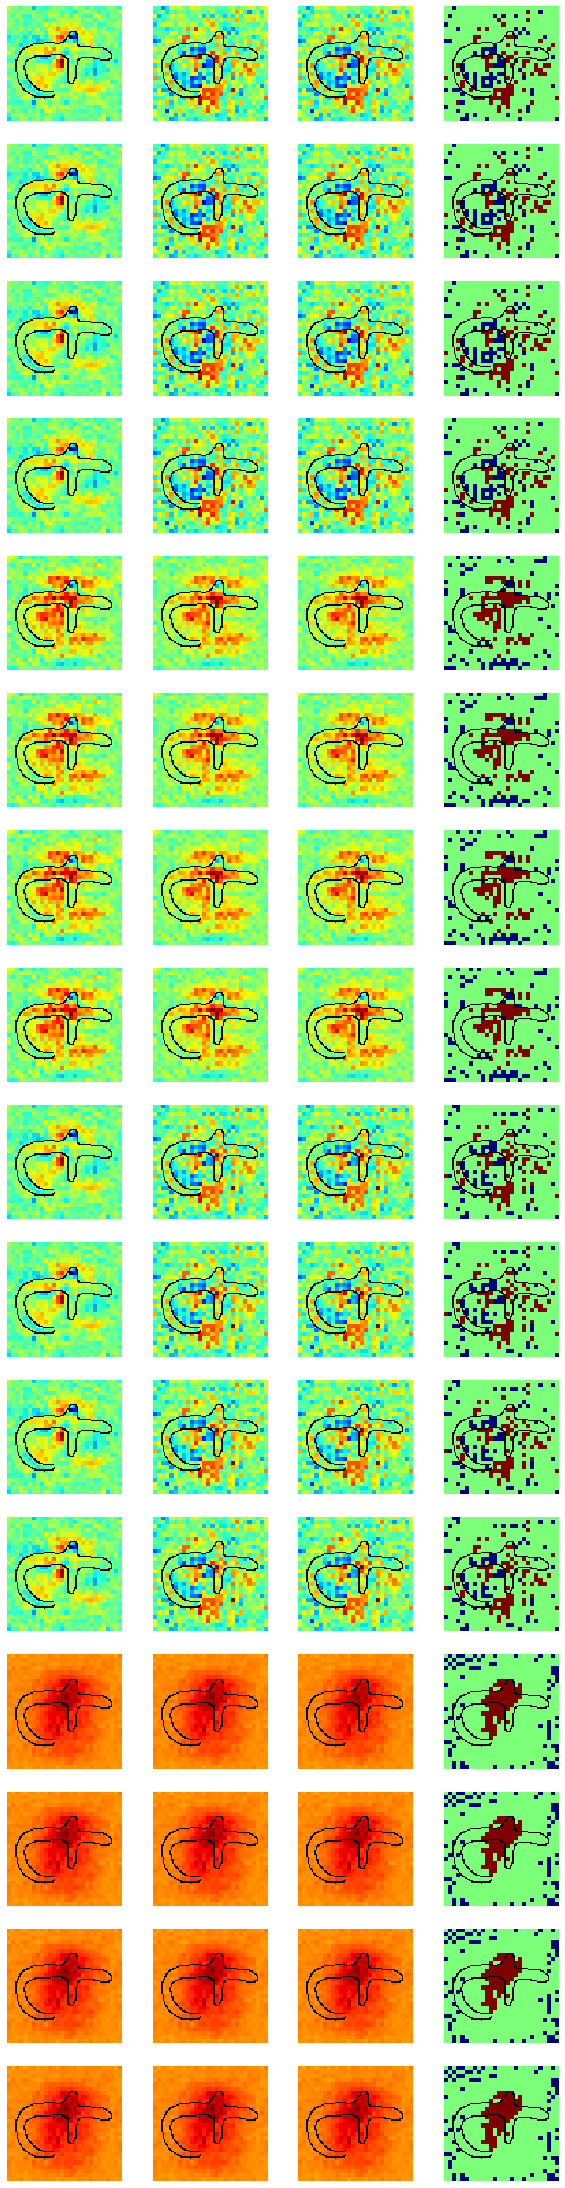

In [75]:

fig, grid = plt.subplots(16, 4, figsize=(10,40)) 


for i in range(len(lrp_type)*4):
#     if i%4 == 0:
#         print("LRP type - ", lrp_type[int(i/4)])
    for j in range(4):
        if(j==0):
            image = hm_base[int(i/4)]
        elif(j==1):
            image = hm_target[lrp_type[int(i/4)]][0]
        elif(j==3):
            image = hm_overlap[i]
        else:
            image = hm_target[lrp_type[int(i/4)]][i%4]
            
        grid[i, j].imshow(image)
        grid[i, j].axis('off')
#     print("-------------------------------------------------")
